In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, pearsonr
from statsmodels.stats.multitest import multipletests
from datetime import datetime

In [289]:
fast_df = pd.read_csv("fast_volumes.csv")      
first_df = pd.read_csv("first_volumes.csv")    
first_df["Group"] = first_df["Group"].str.upper()

data = pd.merge(fast_df, first_df, on=["Subject_ID", "Group"])  # "Group" = CN ili AD

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Group       260 non-null    object
 1   Subject_ID  260 non-null    object
 2   CSF_Volume  260 non-null    int64 
 3   GM_Volume   260 non-null    int64 
 4   WM_Volume   260 non-null    int64 
 5   L_Hipp      260 non-null    int64 
 6   R_Hipp      260 non-null    int64 
 7   L_Thal      260 non-null    int64 
 8   R_Thal      260 non-null    int64 
 9   L_Amyg      260 non-null    int64 
 10  R_Amyg      260 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 22.5+ KB
None


In [290]:
print(data.head())

  Group  Subject_ID  CSF_Volume  GM_Volume  WM_Volume  L_Hipp  R_Hipp  L_Thal  \
0    AD  002_S_1018      489305     745660     524220    3150    3099    6002   
1    AD  002_S_5018      475972     786841     739744    2981    3811    6298   
2    AD  003_S_4136      683549     819887     769084    3436    2432    6035   
3    AD  003_S_4142      395283     710339     676719    2033    2102    4654   
4    AD  003_S_4152      487650     691365     620699    3217    3814    5666   

   R_Thal  L_Amyg  R_Amyg  
0    5595    1259     997  
1    6303    1037     982  
2    5856    1311    1366  
3    4621    1013     559  
4    5989    1257    1218  


In [291]:
volume_cols = data.columns.drop(["Subject_ID", "Group"])
group_CN = data[data['Group'] == 'CN']
group_AD = data[data['Group'] == 'AD']
desc_stats = data.groupby("Group")[volume_cols].agg(['mean', 'std', 'median', 'min', 'max'])
print(desc_stats)

          CSF_Volume                                              GM_Volume  \
                mean           std    median     min     max           mean   
Group                                                                         
AD     494244.884615  60053.081610  490352.0  376722  720392  721721.361538   
CN     488809.938462  63108.567171  485296.5  358451  662643  783531.730769   

                                               ...       L_Amyg              \
                std    median     min     max  ...         mean         std   
Group                                          ...                            
AD     77735.291134  711680.0  514278  920789  ...  1061.269231  250.793710   
CN     74609.787483  788673.0  578820  948202  ...  1184.661538  281.981047   

                               R_Amyg                                 
       median  min   max         mean         std  median  min   max  
Group                                                             

In [292]:
tissue_types = ['CSF_Volume', 'GM_Volume', 'WM_Volume']
subcortical_structures = [col for col in volume_cols if col not in tissue_types]

In [293]:
#test normalnosti (Shapiro-Wilk)
normal = []

for col in volume_cols:
    data_cn = group_CN[col]
    data_ad = group_AD[col]

    stat_cn, p_cn = shapiro(data_cn)
    stat_ad, p_ad = shapiro(data_ad)

    normal.append({
        "Structure": col,
        "p (CN)": p_cn,
        "p (AD)": p_ad,
        "Normal (CN)": p_cn > 0.05,
        "Normal (AD)": p_ad > 0.05
    })

normal_df = pd.DataFrame(normal)
normal_df.to_excel("test_normalnosti_rez.xlsx", index=False)
print("Test normalnosti:")
print(normal_df.sort_values("Structure"))


Test normalnosti:
    Structure    p (CN)    p (AD)  Normal (CN)  Normal (AD)
0  CSF_Volume  0.256409  0.003123         True        False
1   GM_Volume  0.613248  0.615750         True         True
7      L_Amyg  0.051869  0.416295         True         True
3      L_Hipp  0.970856  0.168745         True         True
5      L_Thal  0.067046  0.600013         True         True
8      R_Amyg  0.667213  0.000936         True        False
4      R_Hipp  0.871691  0.168508         True         True
6      R_Thal  0.119218  0.731974         True         True
2   WM_Volume  0.028634  0.240577        False         True


In [294]:
# statisticki test
results = []

for _, row in normal_df.iterrows():
    col = row["Structure"]
    norm_cn = row["Normal (CN)"]
    norm_ad = row["Normal (AD)"]

    data_cn = group_CN[col].dropna()
    data_ad = group_AD[col].dropna()

    if norm_cn and norm_ad:
        stat, p_val = ttest_ind(data_cn, data_ad, equal_var=False)
        test_used = "t-test"
    else:
        stat, p_val = mannwhitneyu(data_cn, data_ad, alternative='two-sided')
        test_used = "Mann–Whitney"

    results.append({
        "Structure": col,
        "Test": test_used,
        "p-vrijednost": p_val
    })

results_df = pd.DataFrame(results)
results_df.to_excel("stat_tests.xlsx", index=False)
print("Rezultati statističkih testova:")
print(results_df.sort_values("p-vrijednost"))


Rezultati statističkih testova:
    Structure          Test  p-vrijednost
3      L_Hipp        t-test  2.149034e-21
4      R_Hipp        t-test  3.808443e-18
1   GM_Volume        t-test  3.275682e-10
5      L_Thal        t-test  7.736111e-07
6      R_Thal        t-test  2.106870e-06
8      R_Amyg  Mann–Whitney  9.519810e-05
7      L_Amyg        t-test  2.377839e-04
0  CSF_Volume  Mann–Whitney  5.913498e-01
2   WM_Volume  Mann–Whitney  9.218215e-01


In [295]:
#  p-vrijednosti 
pvals_dict = dict(zip(results_df["Structure"], results_df["p-vrijednost"]))

In [296]:
def annotate_sig(ax, x_pos, y, p_val):
    """Dodaje samo zvjezdicu iznad boxplota ako je značajno."""
    if p_val < 0.05:
        label = "*"
    else:
        return  # ne dodaje ništa ako nije značajno

    ax.text(x_pos, y, label, ha='center', va='bottom', fontsize=14, color='black')


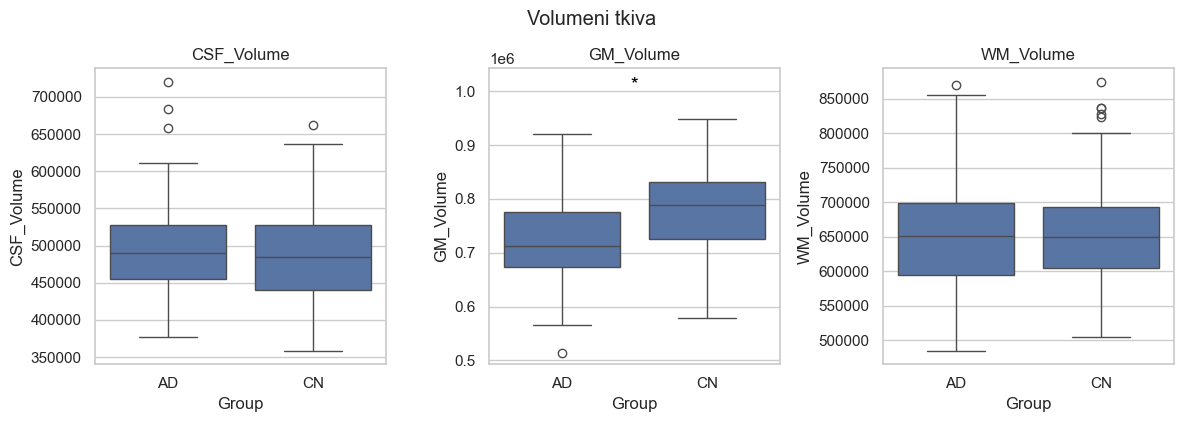

In [297]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(tissue_types):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x="Group", y=col, data=data)
    ax = plt.gca()  
    
    if col in pvals_dict and pvals_dict[col] < 0.05:
        ymax = data[col].max()
        y_pos = ymax + (0.05 * ymax)
        ax.set_ylim(top=y_pos + (0.05 * ymax))  
        annotate_sig(ax, x_pos=0.5, y=y_pos, p_val=pvals_dict[col])  

    plt.title(col)
    plt.tight_layout()
plt.suptitle("Volumeni tkiva", y=1.05)
plt.show()

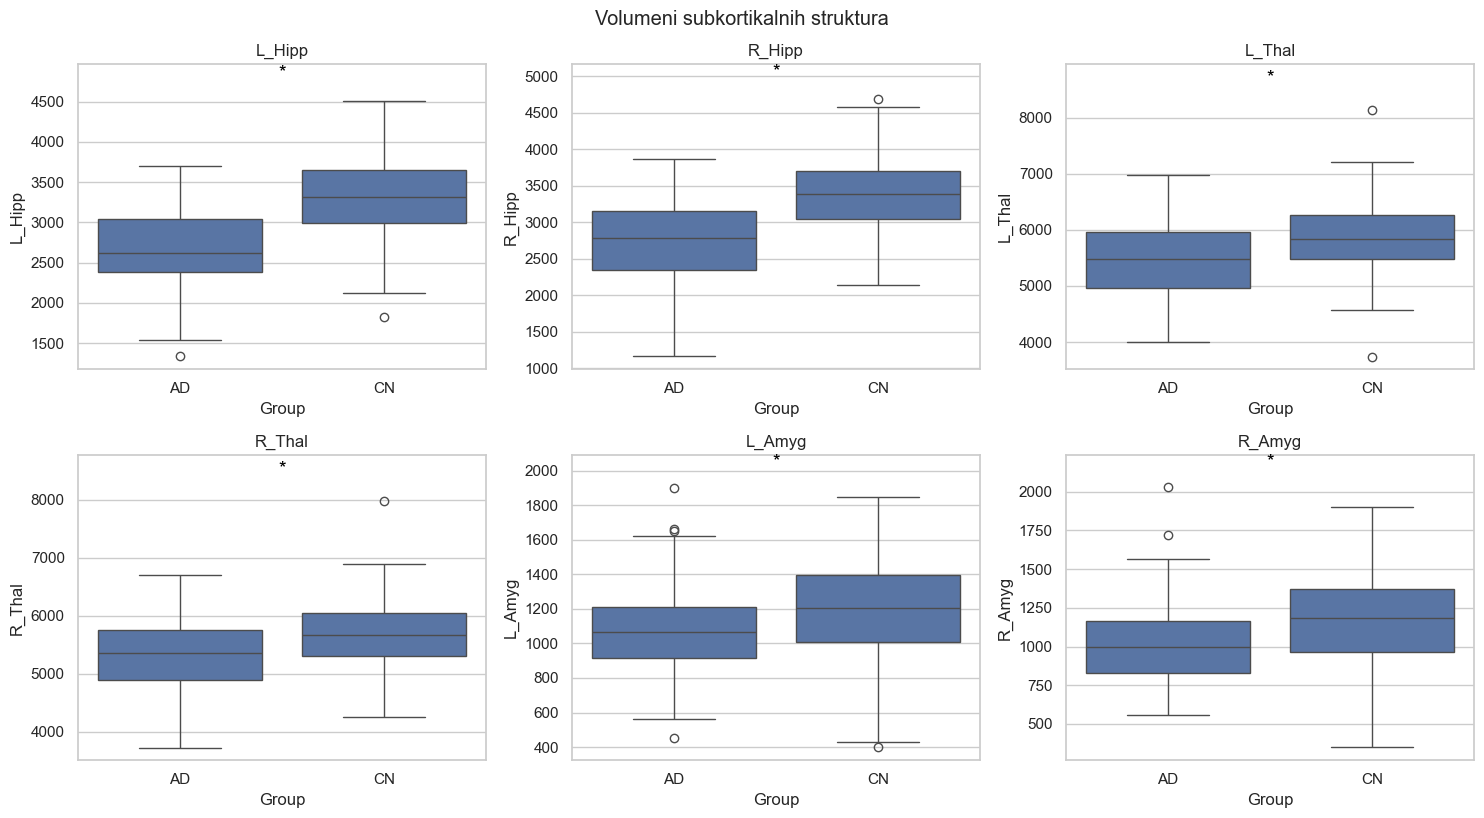

In [298]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(subcortical_structures):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Group', y=col, data=data)
    ax = plt.gca()
    
    if col in pvals_dict and pvals_dict[col] < 0.05:
        ymax = data[col].max()
        y_pos = ymax + (0.05 * ymax)
        ax.set_ylim(top=y_pos + (0.05 * ymax))
        annotate_sig(ax, x_pos=0.5, y=y_pos, p_val=pvals_dict[col])
    plt.title(col)
    plt.tight_layout() 
plt.suptitle("Volumeni subkortikalnih struktura", y=1.02)
plt.show()

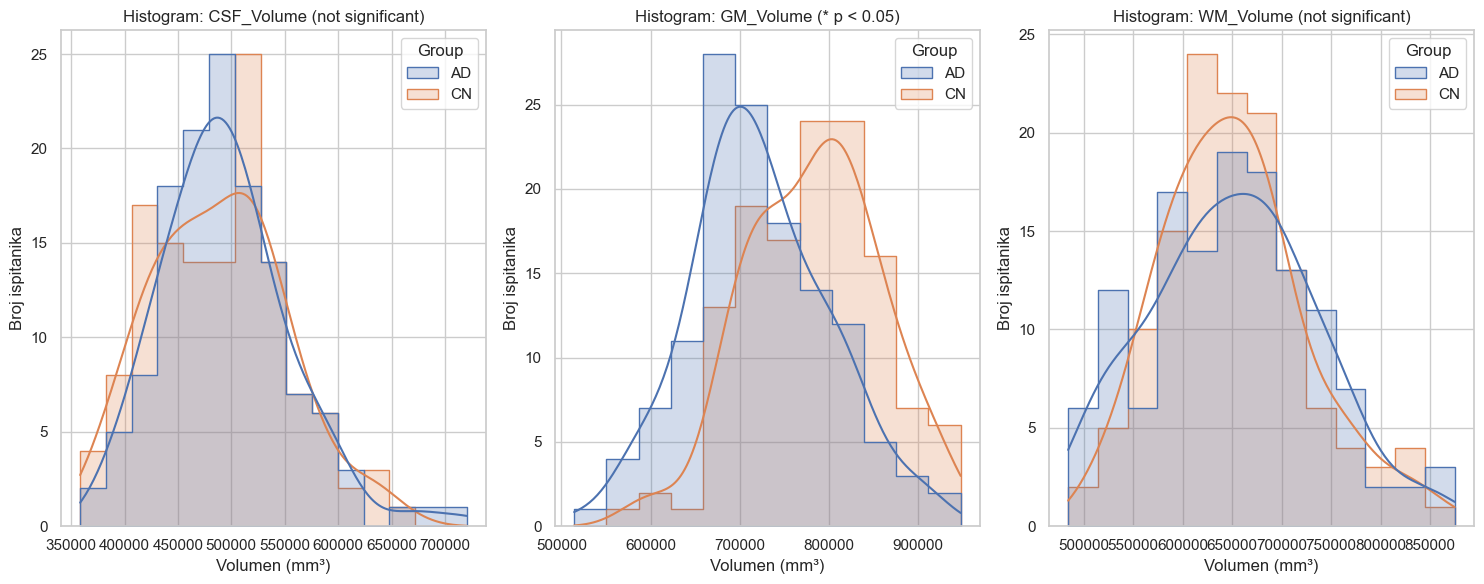

In [299]:
plt.figure(figsize=(15, 6))
for i, region in enumerate(tissue_types):
    plt.subplot(1, 3, i + 1)
    p_val = pvals_dict.get(region, None)

    title = ''
    if p_val is not None:
        if p_val < 0.05:
            title += ' (* p < 0.05)'
        else:
            title += ' (not significant)'

    sns.histplot(data=data, x=region, hue='Group', kde=True, element="step")
    plt.title(f'Histogram: {region}' + title)
    plt.xlabel("Volumen (mm³)")
    plt.ylabel("Broj ispitanika")
plt.tight_layout()
plt.show()

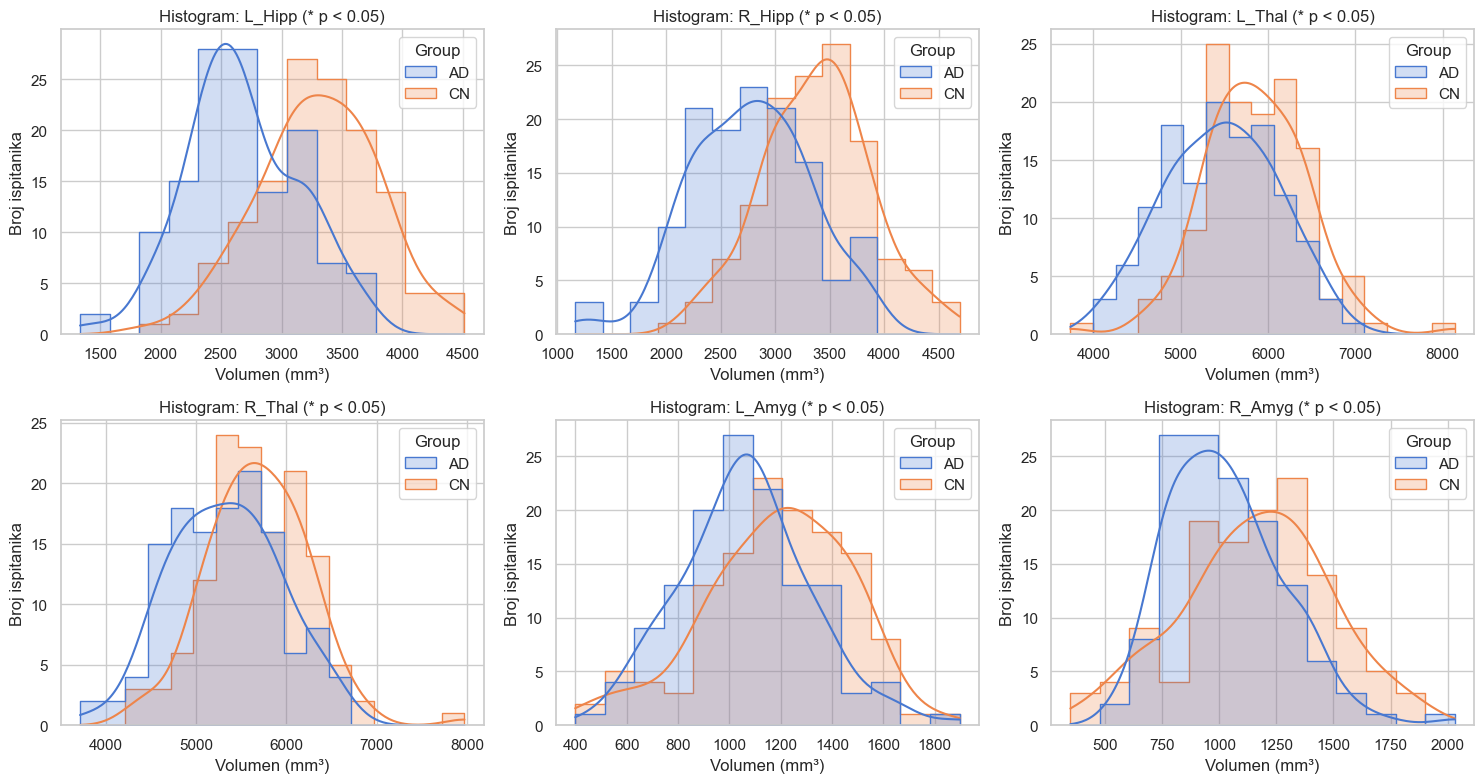

In [300]:
plt.figure(figsize=(15, 8))
for i, region in enumerate(subcortical_structures):
    plt.subplot(2, 3, i + 1)
    p_val = pvals_dict.get(region, None)

    title = ''
    if p_val is not None:
        if p_val < 0.05:
            title += ' (* p < 0.05)'
        else:
            title += ' (not significant)'

    sns.histplot(data=data, x=region, hue='Group', kde=True, element="step", palette='muted')
    plt.title(f'Histogram: {region}' + title)
    plt.xlabel("Volumen (mm³)")
    plt.ylabel("Broj ispitanika")
plt.tight_layout()
plt.show()


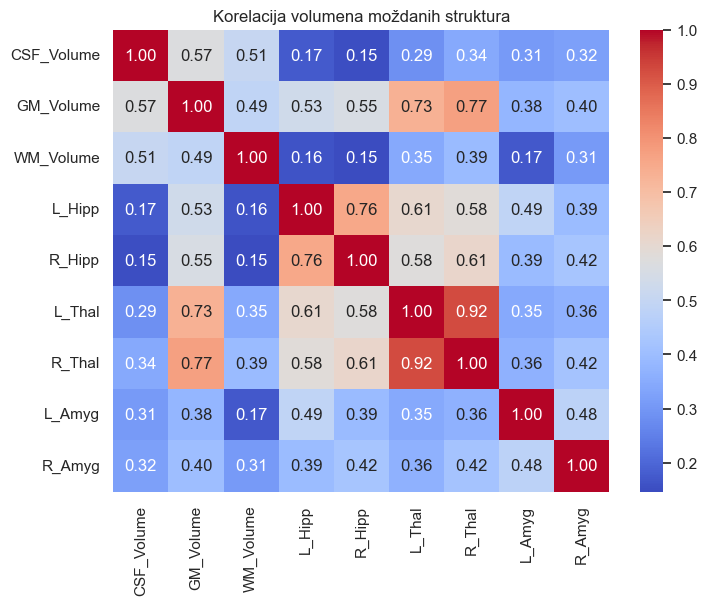

In [301]:
plt.figure(figsize=(8, 6))
corr = data[volume_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelacija volumena moždanih struktura")
plt.show()

In [302]:
demog = pd.read_csv("PTDEMOG.csv")
mmse = pd.read_csv("MMSE.csv")
merged = pd.merge(data, demog, left_on="Subject_ID", right_on="PTID", how="left")

merged["PTDOB"] = pd.to_datetime(merged["PTDOB"], errors="coerce")

def calculate_age(row):
    if pd.notnull(row["PTDOB"]):
        return (datetime.today() - row["PTDOB"]).days // 365
    elif pd.notnull(row["PTDOBYY"]):
        return datetime.year() - int(row["PTDOBYY"])
    else:
        return None

merged["AGE"] = merged.apply(calculate_age, axis=1)

merged["GENDER"] = merged["PTGENDER"].map({1: "Male", 2: "Female"})

merged["EDUCAT_LEVEL"] = merged["PTEDUCAT"]

mmse_clean = mmse.dropna(subset=["MMSCORE"]) 
mmse_first = mmse_clean.sort_values(by="VISDATE").drop_duplicates(subset="PTID", keep="first")[["PTID", "MMSCORE"]]
merged = merged.merge(mmse_first, left_on="Subject_ID", right_on="PTID", how="left")

cols = ["Subject_ID", "AGE", "EDUCAT_LEVEL", "GENDER", "MMSCORE"] + [col for col in data.columns if col != "Subject_ID"]
final_df = merged[cols]

final_df.head()


C:\Users\Ivana\AppData\Local\Temp\ipykernel_16112\1062931809.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged["PTDOB"] = pd.to_datetime(merged["PTDOB"], errors="coerce")


,Subject_ID,AGE,EDUCAT_LEVEL,GENDER,MMSCORE,Group,CSF_Volume,GM_Volume,WM_Volume,L_Hipp,R_Hipp,L_Thal,R_Thal,L_Amyg,R_Amyg
0,002_S_1018,89.0,13.0,Female,26.0,AD,489305,745660,524220,3150,3099,6002,5595,1259,997
1,002_S_5018,86.0,17.0,Male,23.0,AD,475972,786841,739744,2981,3811,6298,6303,1037,982
2,003_S_4136,80.0,20.0,Male,24.0,AD,683549,819887,769084,3436,2432,6035,5856,1311,1366
3,003_S_4142,103.0,16.0,Female,24.0,AD,395283,710339,676719,2033,2102,4654,4621,1013,559
4,003_S_4152,74.0,18.0,Male,20.0,AD,487650,691365,620699,3217,3814,5666,5989,1257,1218


In [303]:
all_data = pd.read_csv("ADNIMERGE.csv")  
all_data = all_data[all_data['COLPROT'] == 'ADNI1']
columns_to_keep = ["PTID", "APOE4"]
adni = all_data[columns_to_keep]
adni.head()

C:\Users\Ivana\AppData\Local\Temp\ipykernel_16112\4172950022.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("ADNIMERGE.csv")


,PTID,APOE4
0,011_S_0002,0.0
1,011_S_0003,1.0
2,011_S_0003,1.0
3,011_S_0003,1.0
4,011_S_0003,1.0


In [304]:
merged = pd.merge(final_df, adni, left_on="Subject_ID", right_on="PTID", how="left")
merged = merged.drop(columns="PTID")
merged = merged.drop_duplicates(subset=['Subject_ID'], keep='first')
merged.head()

,Subject_ID,AGE,EDUCAT_LEVEL,GENDER,MMSCORE,Group,CSF_Volume,GM_Volume,WM_Volume,L_Hipp,R_Hipp,L_Thal,R_Thal,L_Amyg,R_Amyg,APOE4
0,002_S_1018,89.0,13.0,Female,26.0,AD,489305,745660,524220,3150,3099,6002,5595,1259,997,0.0
5,002_S_5018,86.0,17.0,Male,23.0,AD,475972,786841,739744,2981,3811,6298,6303,1037,982,NaN
6,003_S_4136,80.0,20.0,Male,24.0,AD,683549,819887,769084,3436,2432,6035,5856,1311,1366,NaN
7,003_S_4142,103.0,16.0,Female,24.0,AD,395283,710339,676719,2033,2102,4654,4621,1013,559,NaN
8,003_S_4152,74.0,18.0,Male,20.0,AD,487650,691365,620699,3217,3814,5666,5989,1257,1218,NaN


In [305]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Subject_ID    260 non-null    object 
 1   AGE           260 non-null    float64
 2   EDUCAT_LEVEL  260 non-null    float64
 3   GENDER        260 non-null    object 
 4   MMSCORE       260 non-null    float64
 5   Group         260 non-null    object 
 6   CSF_Volume    260 non-null    int64  
 7   GM_Volume     260 non-null    int64  
 8   WM_Volume     260 non-null    int64  
 9   L_Hipp        260 non-null    int64  
 10  R_Hipp        260 non-null    int64  
 11  L_Thal        260 non-null    int64  
 12  R_Thal        260 non-null    int64  
 13  L_Amyg        260 non-null    int64  
 14  R_Amyg        260 non-null    int64  
 15  APOE4         80 non-null     float64
dtypes: float64(4), int64(9), object(3)
memory usage: 34.5+ KB


In [306]:
brain_vars = ['CSF_Volume', 'GM_Volume', 'WM_Volume',
              'L_Hipp', 'R_Hipp', 'L_Thal', 'R_Thal',
              'L_Amyg', 'R_Amyg']

educ_results = []

for var in brain_vars:
    sub_df = merged[['EDUCAT_LEVEL', var]].dropna()
    if not sub_df.empty:
        r, p = pearsonr(sub_df['EDUCAT_LEVEL'], sub_df[var])
        educ_results.append({'Struktura': var, 'r (Pearson)': round(r, 3), 'p-vrijednost': round(p, 4)})
    else:
        educ_results.append({'Struktura': var, 'r (Pearson)': None, 'p-vrijednost': None})

educ_corr_df = pd.DataFrame(educ_results)

print("Rezultati statističkih testova:")
print(educ_corr_df.sort_values("p-vrijednost"))

educ_corr_df.to_excel("stat_education.xlsx", index=False)


Rezultati statističkih testova:
    Struktura  r (Pearson)  p-vrijednost
0  CSF_Volume        0.265        0.0000
1   GM_Volume        0.275        0.0000
5      L_Thal        0.250        0.0000
6      R_Thal        0.314        0.0000
2   WM_Volume        0.225        0.0002
8      R_Amyg        0.204        0.0009
4      R_Hipp        0.190        0.0021
3      L_Hipp        0.178        0.0041
7      L_Amyg        0.097        0.1190


In [307]:
mmse_results = []

for var in brain_vars:
    sub_df = merged[['MMSCORE', var]].dropna()
    if not sub_df.empty:
        r, p = pearsonr(sub_df['MMSCORE'], sub_df[var])
        mmse_results.append({'Struktura': var, 'r (Pearson)': round(r, 3), 'p-vrijednost': round(p, 4)})
    else:
        mmse_results.append({'Struktura': var, 'r (Pearson)': None, 'p-vrijednost': None})

mmse_corr_df = pd.DataFrame(mmse_results)

print("Rezultati statističkih testova:")
print(mmse_corr_df.sort_values("p-vrijednost"))

mmse_corr_df.to_excel("stat_mmse.xlsx", index=False)

Rezultati statističkih testova:
    Struktura  r (Pearson)  p-vrijednost
1   GM_Volume        0.367        0.0000
3      L_Hipp        0.524        0.0000
4      R_Hipp        0.519        0.0000
5      L_Thal        0.349        0.0000
6      R_Thal        0.334        0.0000
8      R_Amyg        0.223        0.0003
7      L_Amyg        0.217        0.0004
0  CSF_Volume       -0.094        0.1321
2   WM_Volume       -0.026        0.6761


In [308]:
from scipy.stats import ttest_ind, chi2_contingency

# Dob (AGE) - numerička varijabla
age_cn = merged[merged["Group"] == "CN"]["AGE"].dropna()
age_ad = merged[merged["Group"] == "AD"]["AGE"].dropna()
t_age, p_age = ttest_ind(age_cn, age_ad, equal_var=False)

# Godine obrazovanja (EDUCAT_LEVEL) - numerička varijabla
edu_cn = merged[merged["Group"] == "CN"]["EDUCAT_LEVEL"].dropna()
edu_ad = merged[merged["Group"] == "AD"]["EDUCAT_LEVEL"].dropna()
t_edu, p_edu = ttest_ind(edu_cn, edu_ad, equal_var=False)

# Spol (GENDER) - kategorijska varijabla
gender_table = pd.crosstab(merged["Group"], merged["GENDER"])
chi2_gender, p_gender, _, _ = chi2_contingency(gender_table)

# APOE4 aleli - kategorijska varijabla
apoe_table = pd.crosstab(merged["Group"], merged["APOE4"])
chi2_apoe, p_apoe, _, _ = chi2_contingency(apoe_table)

# Prikaz rezultata
print("Statistička analiza razlika između CN i AD grupa:\n")
print(f"Dob (AGE): t = {t_age:.3f}, p = {p_age:.4f}")
print(f"Godine obrazovanja (EDUCAT_LEVEL): t = {t_edu:.3f}, p = {p_edu:.4f}")
print(f"Spol (GENDER): chi² = {chi2_gender:.3f}, p = {p_gender:.4f}")
print(f"APOE4 aleli: chi² = {chi2_apoe:.3f}, p = {p_apoe:.4f}")


Statistička analiza razlika između CN i AD grupa:

Dob (AGE): t = -0.015, p = 0.9879
Godine obrazovanja (EDUCAT_LEVEL): t = 3.092, p = 0.0022
Spol (GENDER): chi² = 0.000, p = 1.0000
APOE4 aleli: chi² = 14.936, p = 0.0006


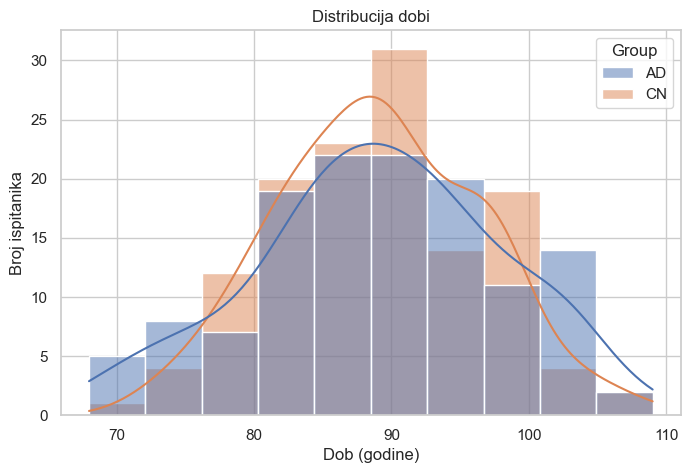

In [309]:
plt.figure(figsize=(8, 5))
sns.histplot(data=merged, x="AGE", hue="Group", kde=True, bins=10)
plt.title("Distribucija dobi")
plt.xlabel("Dob (godine)")
plt.ylabel("Broj ispitanika")
plt.show()

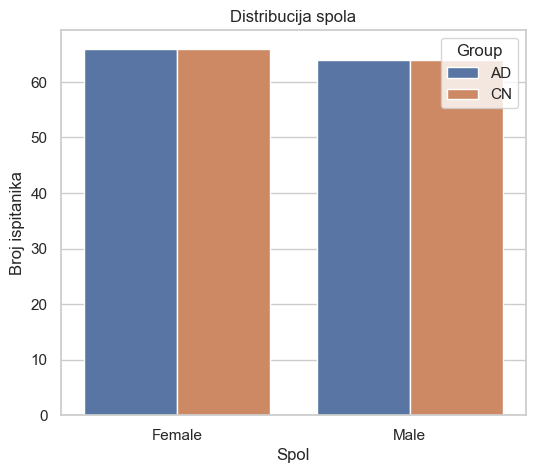

In [310]:
plt.figure(figsize=(6, 5))
sns.countplot(data=merged, x="GENDER", hue="Group")
plt.title("Distribucija spola")
plt.xlabel("Spol")
plt.ylabel("Broj ispitanika")
plt.show()

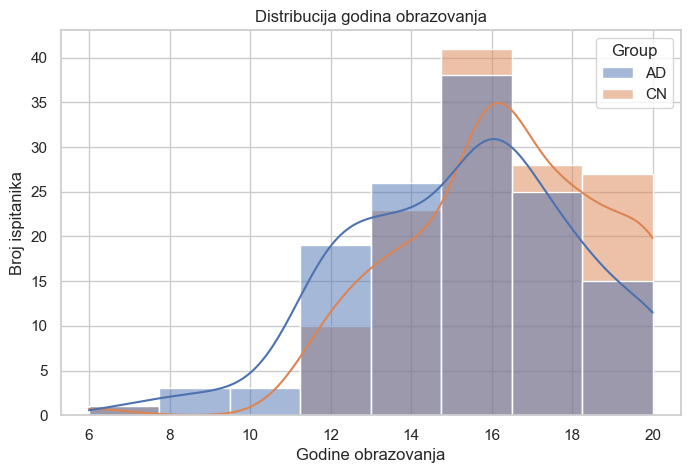

In [311]:
plt.figure(figsize=(8, 5))
sns.histplot(data=merged, x="EDUCAT_LEVEL", hue="Group", kde=True, bins=8)
plt.title("Distribucija godina obrazovanja")
plt.xlabel("Godine obrazovanja")
plt.ylabel("Broj ispitanika")
plt.show()

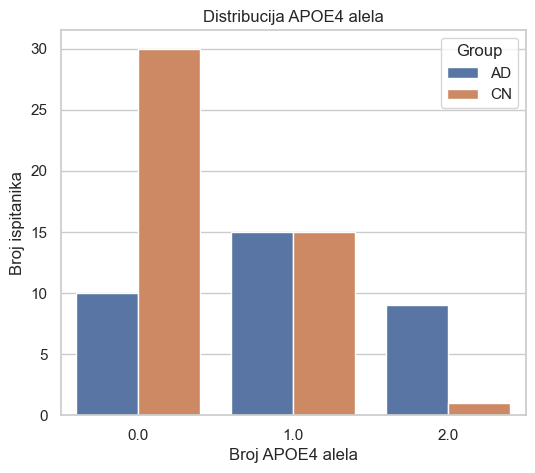

In [312]:
plt.figure(figsize=(6, 5))
sns.countplot(data=merged, x="APOE4", hue="Group")
plt.title("Distribucija APOE4 alela")
plt.xlabel("Broj APOE4 alela")
plt.ylabel("Broj ispitanika")
plt.show()

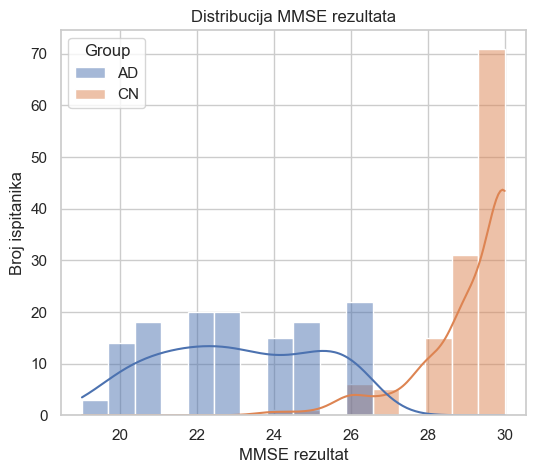

In [313]:
plt.figure(figsize=(6, 5))
sns.histplot(data=merged, x="MMSCORE", hue="Group", kde=True, bins=16)
plt.title("Distribucija MMSE rezultata")
plt.xlabel("MMSE rezultat")
plt.ylabel("Broj ispitanika")
plt.show()

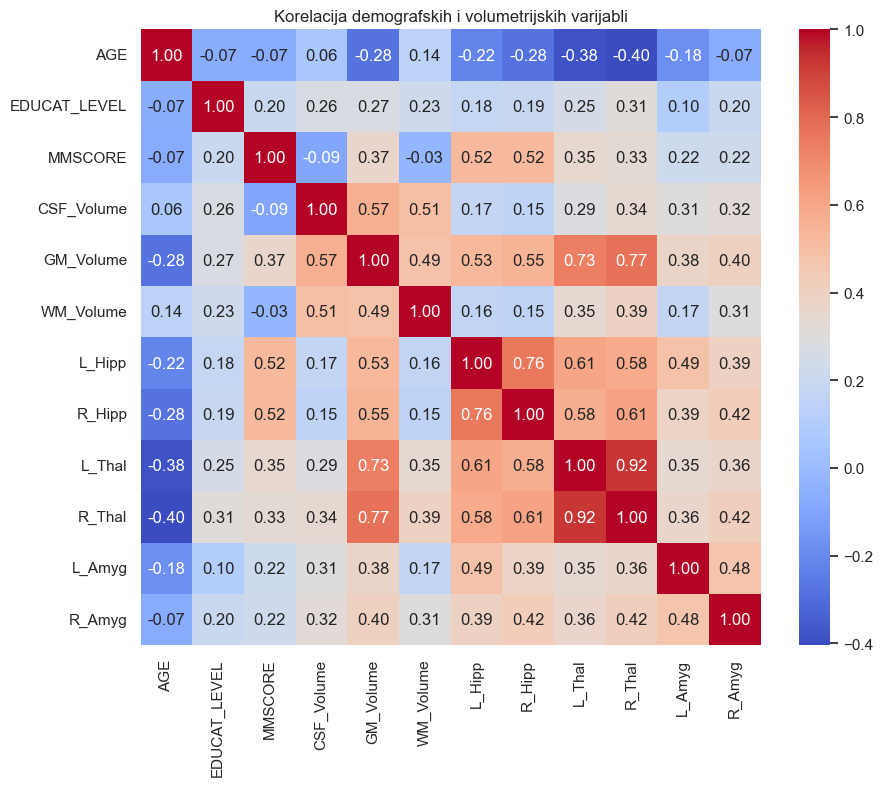

In [314]:
corr_vars = ["AGE", "EDUCAT_LEVEL", "MMSCORE", "CSF_Volume", "GM_Volume", "WM_Volume", 
             "L_Hipp", "R_Hipp", "L_Thal", "R_Thal", "L_Amyg", "R_Amyg"]

corr_matrix = merged[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelacija demografskih i volumetrijskih varijabli")
plt.show()


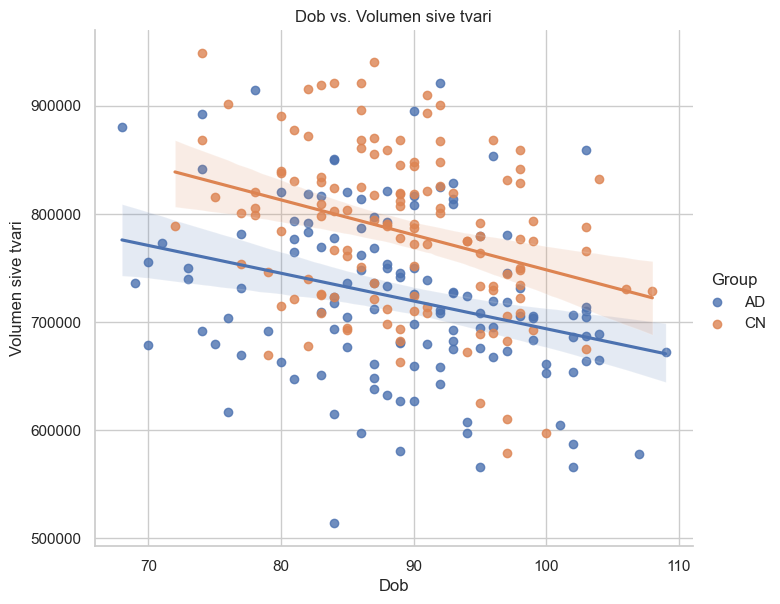

In [315]:
sns.lmplot(data=merged, x="AGE", y="GM_Volume", hue="Group", height=6, aspect=1.2)
plt.title("Dob vs. Volumen sive tvari")
plt.xlabel("Dob")
plt.ylabel("Volumen sive tvari")
plt.show()


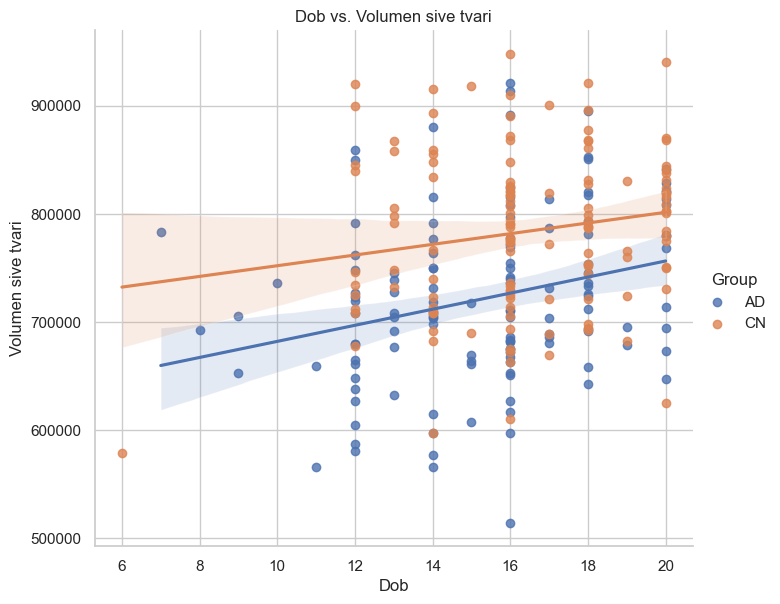

In [316]:
sns.lmplot(data=merged, x="EDUCAT_LEVEL", y="GM_Volume", hue="Group", height=6, aspect=1.2)
plt.title("Dob vs. Volumen sive tvari")
plt.xlabel("Dob")
plt.ylabel("Volumen sive tvari")
plt.show()


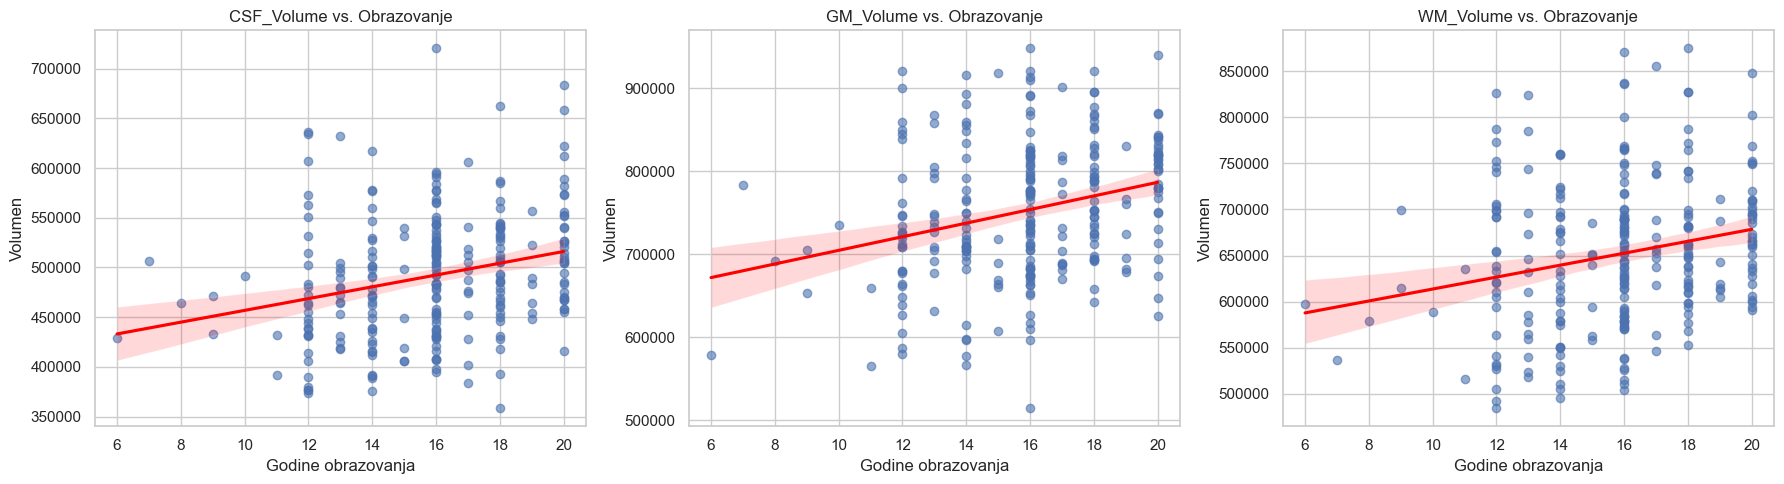

In [317]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 3 tkiva: CSF, GM, WM
tissue_vars = ['CSF_Volume', 'GM_Volume', 'WM_Volume']
for i, var in enumerate(tissue_vars):
    sns.regplot(data=merged, x='EDUCAT_LEVEL', y=var, ax=axes[i], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    axes[i].set_title(f'{var} vs. Obrazovanje')
    axes[i].set_xlabel('Godine obrazovanja')
    axes[i].set_ylabel('Volumen')

plt.tight_layout()
plt.show()


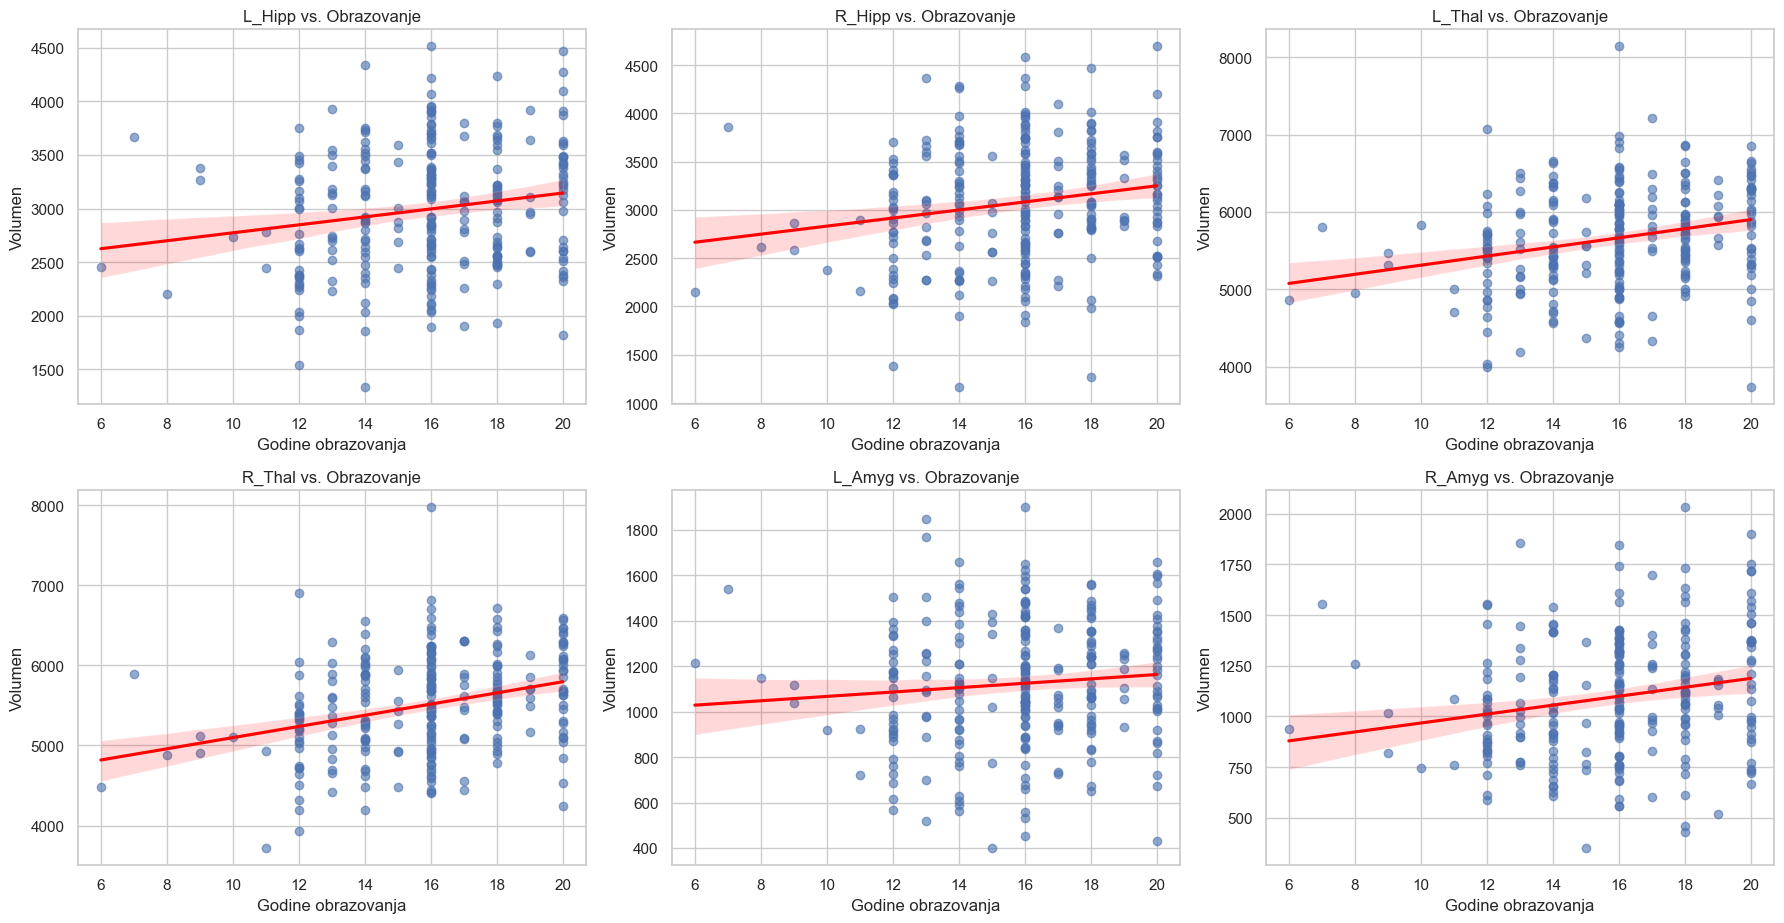

In [318]:
subcortical_vars = ['L_Hipp', 'R_Hipp', 'L_Thal', 'R_Thal', 'L_Amyg', 'R_Amyg']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(subcortical_vars):
    ax = axes[i//3, i%3]
    sns.regplot(data=merged, x='EDUCAT_LEVEL', y=var, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax.set_title(f'{var} vs. Obrazovanje')
    ax.set_xlabel('Godine obrazovanja')
    ax.set_ylabel('Volumen')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


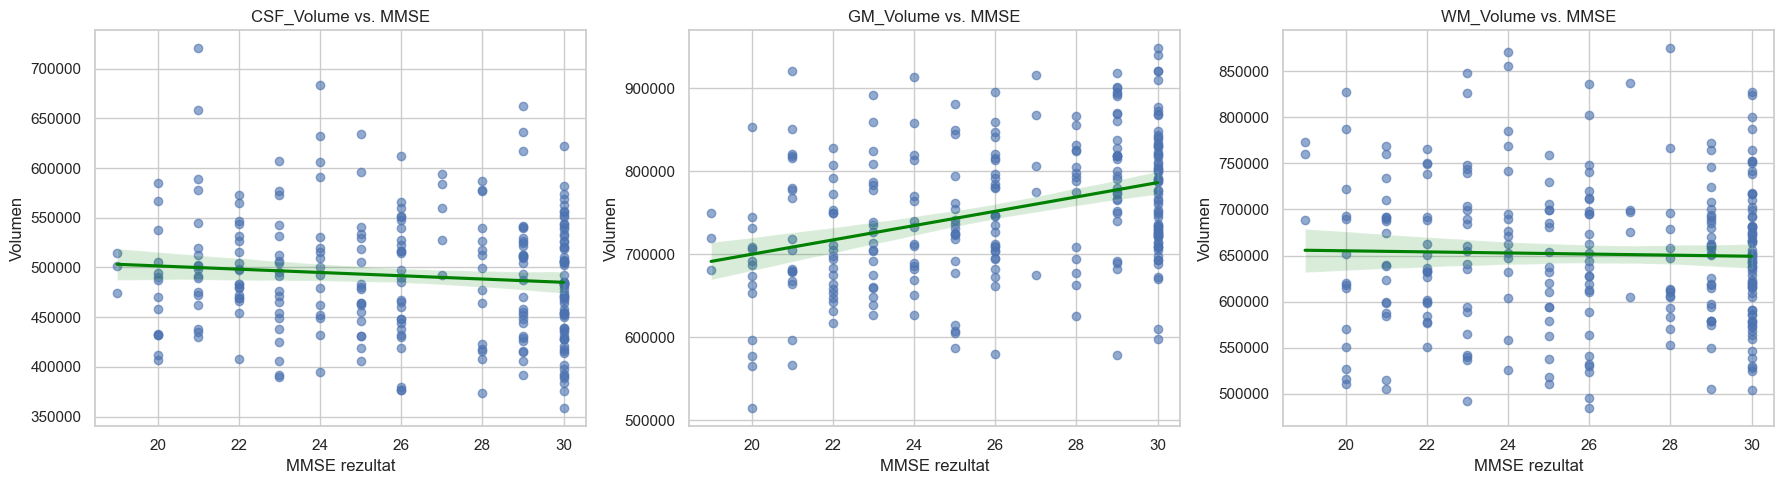

In [319]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(tissue_vars):
    sns.regplot(data=merged, x='MMSCORE', y=var, ax=axes[i], scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
    axes[i].set_title(f'{var} vs. MMSE')
    axes[i].set_xlabel('MMSE rezultat')
    axes[i].set_ylabel('Volumen')

plt.tight_layout()
plt.show()


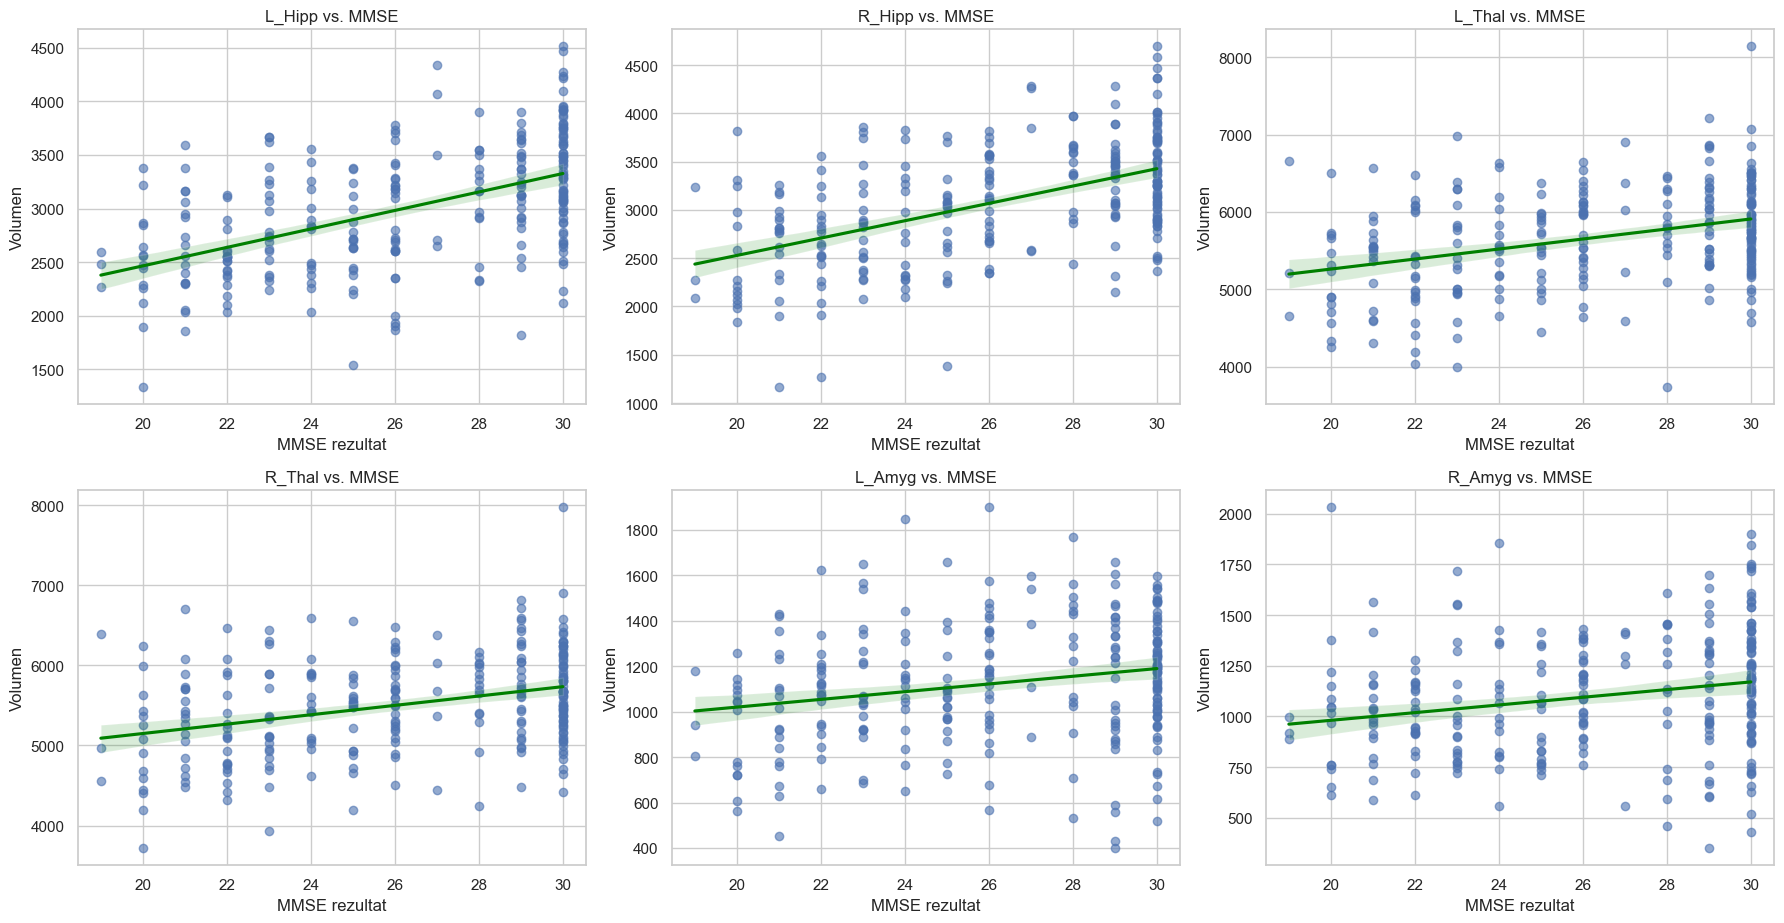

In [320]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(subcortical_vars):
    ax = axes[i//3, i%3]
    sns.regplot(data=merged, x='MMSCORE', y=var, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
    ax.set_title(f'{var} vs. MMSE')
    ax.set_xlabel('MMSE rezultat')
    ax.set_ylabel('Volumen')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
